# M² Experimental Design

**Scott Prahl**

**Sept 2023**

The basic idea for measuring M² is simple.  Use a CCD imager to capture changing beam profile at different points along the direction of propagation.  Doing this accurately is a challenge because the beam must always fit within camera sensor and the measurement locations should include both points near the focus and far from the focus.  Moreover, in most situations, the focus is not accessible.  In this case a lens is used to create an artificial focus that can be measured.

One of the nice properties of M² is that it is not affected by refocusing: the artificially focused beam will have different beam waist and Rayleigh distances but the M² value will be the same as the original beam.

This notebook describes a set of constraints for selection of an imaging lens and then gives an example of a successful measurement and an unsuccessful measurement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

pixel_size = 3.75e-6  # pixel size in m
pixel_size_mm = pixel_size * 1e3
pixel_size_µm = pixel_size * 1e6

## Designing an M² measurement

We first need to to figure out the focal length of the lens that will be used.  The design example that we will use is for a low divergence beam.  (High divergence lasers (e.g. diodes) are more suited to other techniques.)

Obviously, we do not want to introduce experimental artifacts into the measurement and therefore we want to minimize introducing wavefront aberrations with the lens.  In general, to avoid spherical aberrations the f-number (the focal length divided by the beam diameter) of the lens should be over 20.  For a low divergence beam the beam diameter will be about 1mm at the lens and, as we will see below, the allowed f-numbers will all be much greater than 20 and we don't need to worry about it further (as long as a plano-convex lens or doublet is used in the right orientation).

### Creating an artificial focus

An example of beam propagation is shown below.  The beam waist is at -500mm and a lens is located at 0mm.  The beam cross section is exaggerated because the aspect ratio on the axes is 1000:1.

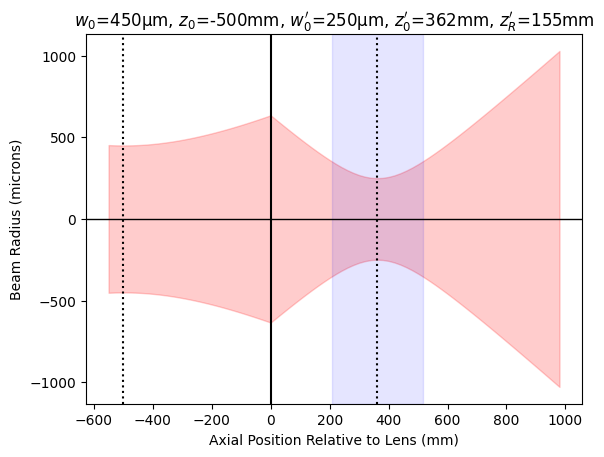

In [2]:
lambda0 = 632.8e-9  # wavelength of light [m]
w0 = 450e-6  # radius at beam waist [m]
f = 300e-3  # focal length of lens [m]

lbs.M2_focus_plot(w0, lambda0, f, z0=-500e-3, M2=2)
plt.show()

### Axial measurement positions

The ISO 11146-1 document, [Lasers and laser-related equipment - Test methods for laser beam widths, divergence angles and beam propagation, Part 1: Stigmatic and simple astigmatic beams](https://www.iso.org/obp/ui/#iso:std:iso:11146:-1:ed-1:v1:en) gives specific instructions for how to measure the M² value.

> If the beam waist is accessible for direct measurement, the beam waist location, beam widths, divergence angles and beam propagation ratios shall be determined by a hyperbolic fit to different measurements of the beam width along the propagation axis $z$. Hence, measurements at at least 10 different $z$ positions shall be taken. Approximately half of the measurements shall be distributed within one Rayleigh length on either side of the beam waist, and approximately half of them shall be distributed beyond two Rayleigh lengths from the beam waist. For simple astigmatic beams this procedure shall be applied separately for both principal directions.

In the picture above, the artificial beam waist is at 362mm and the Rayleigh distance for the artificial beam is 155mm.  Therefore, to comply with the requirements above, five measurements should be made between 207 and 517mm of the lens and then five more at distances greater than 672mm.  One possibility might be the ten measurements shown below.

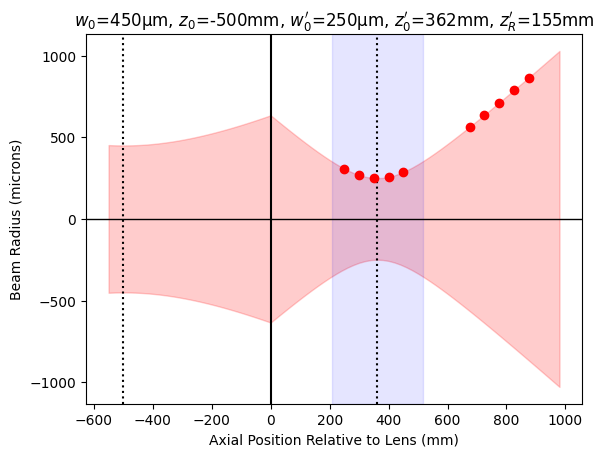

In [3]:
lambda0 = 632.8e-9  # wavelength of light [m]
w0 = 450e-6  # radius at beam waist [m]
f = 300e-3  # focal length of lens [m]

z = np.array([250, 300, 350, 400, 450, 675, 725, 775, 825, 875]) * 1e-3
lbs.M2_focus_plot(w0, lambda0, f, z0=-500e-3, M2=2)
r = lbs.beam_radius(250e-6, lambda0, z, z0=362e-3, M2=2)
plt.plot(z * 1e3, r * 1e6, "or")
plt.show()

### Camera sensor size constraints

If the beam is centered on the camera sensor then should be larger than 20 pixels and it should less than 1/4 of the narrower sensor dimension.  The first constraint is critical for weakly divergent beams (e.g., HeNe) and the second is critical for strongly divergent beams (e.g., diode laser).

For a HeNe, this ensures that the focal length of the lens should be greater than 100mm.  If we want 40 pixel diameters then the requirement is that the focal length must be more than 190mm.

(Use M²=1 so that the beam size is smallest possible.)

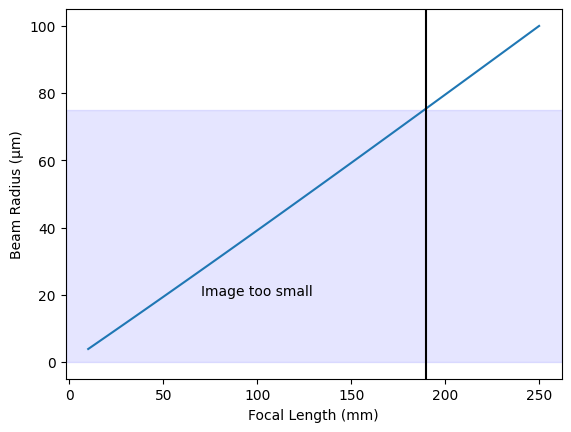

In [4]:
w0 = (1e-3) / 2
lambda0 = 632.8e-9
f = np.linspace(10, 250) * 1e-3
s = -400e-3

max_size = 960 * 0.25 * pixel_size_µm
min_size = 20 * pixel_size_µm
w0_artificial = w0 * lbs.magnification(w0, lambda0, s, f, M2=1)
plt.plot(f * 1e3, w0_artificial * 1e6)
plt.axhspan(min_size, 0, color="blue", alpha=0.1)
plt.text(70, 20, "Image too small")
plt.xlabel("Focal Length (mm)")
plt.ylabel("Beam Radius (µm)")
plt.axvline(190, color="black")
plt.show()

### Working size constraints (i.e., the optical table is only so big)

The measurements must be made on an optical table.  Now, while mirrors could be used to bounce the light around the table, this makes exact measurements of the lens to the camera sensor difficult.  Thus we would like the distance from the lens to the focus + 4 Rayleigh distances to be less than a meter.

Longer focal length lenses reduce the relative error in the positioning of the camera sensor relative to the lens.  If one is doing these measurements by hand then ±1mm might be a typical positioning error.  A motorized stage could minimize such errors, but who has the money for a stage that moves half of a meter!

This means the focal distance needs to be less than 320mm.  However, at this distance, the beam becomes too large and the largest focal length lens is now about 275mm.

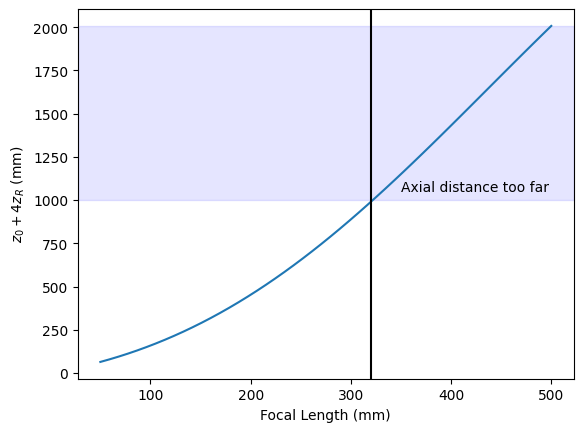

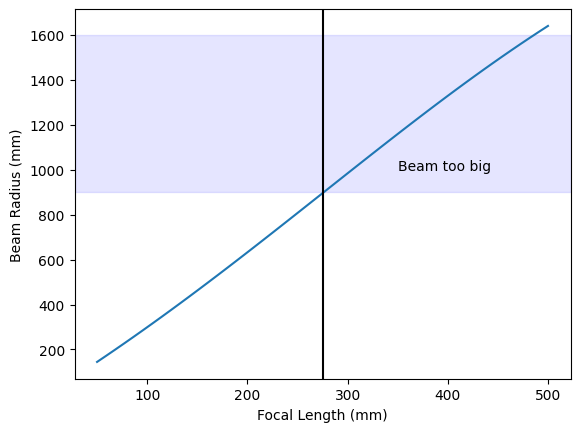

In [5]:
w0 = 1e-3 / 2
lambda0 = 632.8e-9
f = np.linspace(50, 500) * 1e-3
s = -400e-3
M2 = 2

w0_artificial = w0 * lbs.magnification(w0, lambda0, s, f, M2=M2)
z0_artificial = lbs.image_distance(w0, lambda0, s, f, M2=M2)
zR_artificial = lbs.z_rayleigh(w0_artificial, lambda0, M2=M2)

lens_to_4zr_distance = z0_artificial + 4 * zR_artificial

plt.plot(f * 1e3, lens_to_4zr_distance * 1e3)
plt.axhspan(1000, lens_to_4zr_distance[-1] * 1e3, color="blue", alpha=0.1)
plt.text(350, 1050, "Axial distance too far")
plt.xlabel("Focal Length (mm)")
plt.ylabel("$z_0+4z_R$ (mm)")
plt.axvline(320, color="black")
plt.show()

radius_at_4zr = lbs.beam_radius(w0_artificial, lambda0, lens_to_4zr_distance, z0=z0_artificial, M2=M2)

max_size = 960 * 0.25 * pixel_size_µm
plt.plot(f * 1e3, radius_at_4zr * 1e6)
plt.axhspan(1600, max_size, color="blue", alpha=0.1)
plt.text(350, 1000, "Beam too big")
plt.axvline(275, color="black")
plt.xlabel("Focal Length (mm)")
plt.ylabel("Beam Radius (mm)")
plt.show()

### Putting it all together

The focal length of the lens to measure a multimode HeNe beam should then be between 190 and 275 mm.  Here is what a reasonable set of measurements should be for a f=250mm lens.

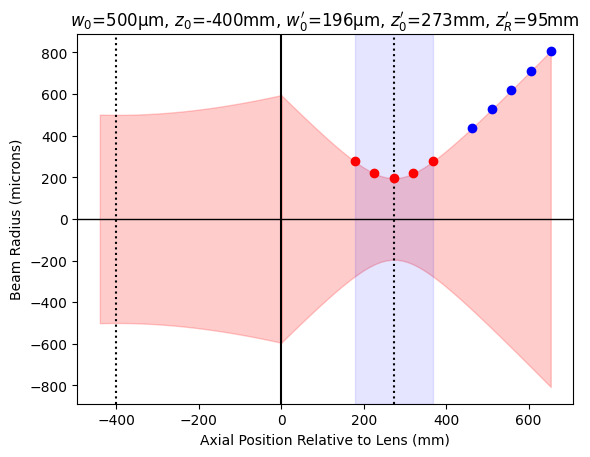

In [6]:
lambda0 = 632.8e-9  # wavelength of light [m]
w0 = 500e-6  # radius at beam waist [m]
f = 250e-3  # focal length of lens [m]
s = -400e-3  # beam waist in laser to lens distance [m]
M2 = 2

lbs.M2_focus_plot(w0, lambda0, f, z0=s, M2=M2)

z0_after = lbs.image_distance(w0, lambda0, s, f, M2=M2)
w0_after = w0 * lbs.magnification(w0, lambda0, s, f, M2=M2)
zR_after = lbs.z_rayleigh(w0_after, lambda0, M2=M2)

zn = np.linspace(z0_after - zR_after, z0_after + zR_after, 5)
zf = np.linspace(z0_after + 2 * zR_after, z0_after + 4 * zR_after, 5)

rn = lbs.beam_radius(w0_after, lambda0, zn, z0=z0_after, M2=2)
rf = lbs.beam_radius(w0_after, lambda0, zf, z0=z0_after, M2=2)

plt.plot(zn * 1e3, rn * 1e6, "or")
plt.plot(zf * 1e3, rf * 1e6, "ob")

plt.show()

## Good spacing of beam size measurements

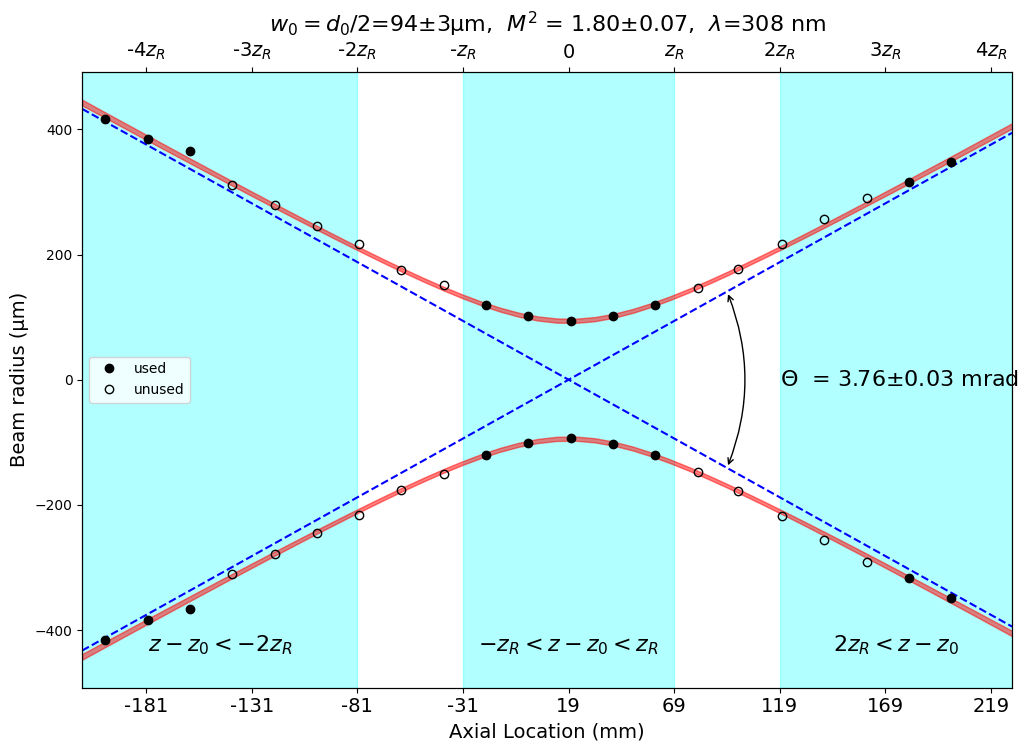

In [7]:
# datapoints digitized by hand from the graph at https://www.rp-photonics.com/beam_quality.html
lambda1 = 308e-9
z1_all = (
    np.array(
        [
            -200,
            -180,
            -160,
            -140,
            -120,
            -100,
            -80,
            -60,
            -40,
            -20,
            0,
            20,
            40,
            60,
            80,
            99,
            120,
            140,
            160,
            180,
            200,
        ]
    )
    * 1e-3
)
d1_all = (
    2
    * np.array(
        [
            416,
            384,
            366,
            311,
            279,
            245,
            216,
            176,
            151,
            120,
            101,
            93,
            102,
            120,
            147,
            177,
            217,
            256,
            291,
            316,
            348,
        ]
    )
    * 1e-6
)

lbs.M2_radius_plot(z1_all, d1_all, lambda1, strict=True)

## Poor spacing of beam size measurements

A nice fit of the beam is achieved, however the fitted value for M²<1.  This is impossible.  Basically the problem boils down to the fact that the measurements in the beam waist are terrible for determining the actual divergence of the beam.  The fit then severely underestimates the divergence of the beam and claims that the beam diverges more slowly than a simple Gaussian beam!!

Invalid distribution of measurements for ISO 11146
9 points within 1 Rayleigh distance
0 points greater than 2 Rayleigh distances


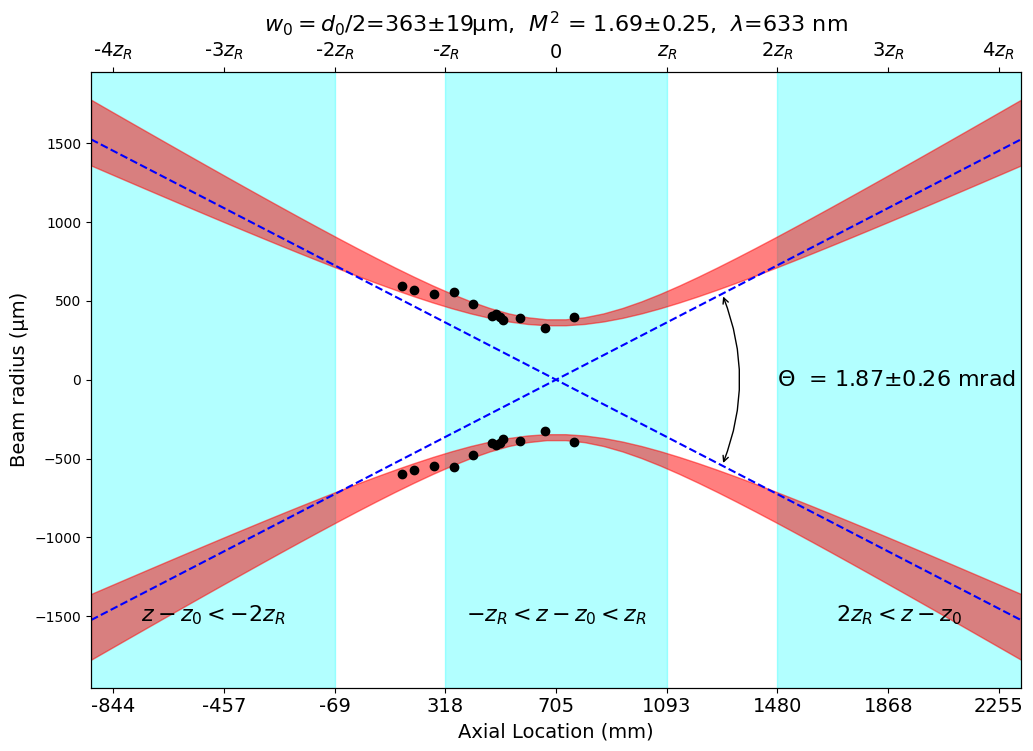

In [8]:
## Some Examples
f = 500e-3  # m
lambda2 = 632.8e-9  # m
z2_all = np.array([168, 210, 280, 348, 414, 480, 495, 510, 520, 580, 666, 770]) * 1e-3  # [m]
d2_all = 2 * np.array([597, 572, 547, 554, 479, 404, 415, 399, 377, 391, 326, 397]) * 1e-6  # [m]

lbs.M2_radius_plot(z2_all, d2_all, lambda2, strict=True)
plt.show()